# 🔊🎧 Moodify
**Moodify is a music recommendation system that uses AI to detect emotions from a person’s speech and suggest songs that match their mood, enhancing personalization and emotional relevance**
## Method 1
 
This project takes an audio file (like someone speaking) and does two main things:

1. Detects the Emotion in the Audio by building neural networks to analyze the sound features of the audio.
    It extracts features like pitch, tone, rhythm, MFCCs, spectral properties using librosa.
    The model predicts the speaker's emotion from one of the categories:

        😠 ANG (Angry)
        😢 SAD (Sad)
        😀 HAP (Happy)
        😐 NEU (Neutral)
        😨 FEA (Fear)
        😒 DIS (Disgust)

2. Recommends Music Based on the Emotion
    Once the emotion is predicted, it connects to the Spotify API and it maps the emotion to a suitable music genre:

        Happy → Pop
        Sad → Classical
        Angry → Rock
        Neutral → Chill
        Fear → Metal
        Disgust → Emo

    It fetches and prints the top 5 Spotify tracks for that genre.

### 💡 Key Features:
       -  End-to-end audio processing using librosa
       -  Emotion prediction using a CNN model
       -  5-fold cross-validation to validate accuracy
        - SMOTE for handling class imbalance
        - Spotify integration for music recommendations(Content based filtering)
        - Clean visualizations (confusion matrix, training plots)

### 🪜 Steps:

 🔹1. Imports and Setup
Loads all required libraries for audio processing, machine learning, deep learning, plotting, and Spotify API.

🔹 2. Feature Extraction
Extracts a rich set of audio features using librosa from .wav files:

        - Zero Crossing Rate, RMSE
        - Spectral features (centroid, bandwidth, rolloff, contrast)
        - MFCC (mean + std of 40 coefficients)
        - Chroma, Mel Spectrogram, Tonnetz
        - Harmonic and Percussive components

🔹 3. Load and Prepare Data
        - Reads all audio file paths from the AudioWAV directory.
        - Extracts features and labels from filenames (emotion tags).
        - Encodes labels using LabelEncoder.

🔹 4. Normalize and Balance
       -  Normalizes features using StandardScaler.
       -  Applies SMOTE to balance imbalanced classes by oversampling the minority classes.
       -  One-hot encodes the labels for classification.

🔹 5. Build CNN Model
Defines a 1D CNN model using:
        - 2 Conv1D layers → BatchNorm → MaxPooling → Dropout
        - Flatten → Dense → Dropout → Output Softmax layer
        - Uses Adam optimizer and categorical crossentropy.

🔹 6. 5-Fold Cross-Validation
        - Performs stratified 5-fold CV to evaluate model performance on different splits.
        - Saves the best model (based on validation accuracy).
        - Tracks per-fold accuracy and training history.

🔹 7. Plot Accuracy and Loss
Plots training vs validation accuracy and loss curves for each fold.

🔹 8. Final Evaluation on All Data
        - Loads the best-performing model.
        - Predicts on the whole dataset.
        - Prints classification report and confusion matrix to evaluate accuracy.

🔹 9. Spotify Music Recommendation
        - Connects to Spotify using spotipy.
        - Maps predicted emotion (e.g., HAP → pop) to genre.
        - Recommends top 5 tracks from that genre.

🔹 10. Predict and Recommend 
        - Takes a .wav file, extracts features, and predicts emotion using the best model.
        - Prints emotion probabilities and recommends matching music.

🔹 11. Test on Example Files
Runs prediction and recommendation on test files.

In [1]:
# ---------------------- Step 1 :  Imports and Setup ----------------------
import os
import numpy as np
import librosa
import glob
import spotipy
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import  Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
#disable warnings
warnings.filterwarnings('ignore')

In [3]:
#Install required packages
!pip install -r requirements.txt

## Phase 1 : Audio Processing

In [4]:
# ---------------------- Step 2 : Feature Extraction ----------------------
def extract_features(audio_files, sr=22050, n_mfcc=40, hop_length=512):
    features_list = []
    for file in audio_files:
        audio, _ = librosa.load(file, sr=sr)
        audio, _ = librosa.effects.trim(audio, top_db=30)

        features = []
        zcr = librosa.feature.zero_crossing_rate(audio, hop_length=hop_length)
        rmse = librosa.feature.rms(y=audio, hop_length=hop_length)
        features.extend([np.mean(zcr), np.std(zcr), np.mean(rmse), np.std(rmse)])

        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=hop_length)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr, hop_length=hop_length)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, hop_length=hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, hop_length=hop_length)
        features.extend([np.mean(spectral_centroid), np.std(spectral_centroid),
                         np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
                         np.mean(spectral_rolloff), np.std(spectral_rolloff),
                         *np.mean(spectral_contrast, axis=1), *np.std(spectral_contrast, axis=1)])

        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        features.extend([np.mean(mfcc[i]) for i in range(n_mfcc)])
        features.extend([np.std(mfcc[i]) for i in range(n_mfcc)])

        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=hop_length)
        features.extend([np.mean(chroma[i]) for i in range(12)])
        features.extend([np.std(chroma[i]) for i in range(12)])

        mel = librosa.feature.melspectrogram(y=audio, sr=sr, hop_length=hop_length)
        features.extend([np.mean(mel), np.std(mel)])

        tonnetz = librosa.feature.tonnetz(y=audio, sr=sr)
        features.extend([np.mean(tonnetz[i]) for i in range(6)])

        y_harmonic, y_percussive = librosa.effects.hpss(audio)
        features.extend([np.mean(y_harmonic), np.std(y_harmonic), np.mean(y_percussive), np.std(y_percussive)])

        features_list.append(features)
    return np.array(features_list)

# ---------------------- Step 3 : Load & Prepare Data ----------------------
CREMA_PATH = "AudioWAV/"
audio_files = glob.glob(os.path.join(CREMA_PATH, "*.wav"))
labels = [os.path.basename(f).split("_")[2] for f in audio_files]

X = extract_features(audio_files)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# ----------------------Step 4 :  Normalize and Balance ----------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
y_cat = to_categorical(y_resampled)

## Phase 2 : Speech Emotion Recognition

In [5]:
# ----------------------Step 5: Build Model Function ----------------------
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ---------------------- Step 6 : 5-Fold Cross Validation ----------------------
print("Running 5-Fold Cross Validation")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_reshaped = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)

fold_accuracies = []
histories = []
best_val_acc = 0

for fold, (train_idx, val_idx) in enumerate(kf.split(X_reshaped, y_resampled)):
    print(f"\nFold {fold+1}")
    X_train, X_val = X_reshaped[train_idx], X_reshaped[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]

    model = create_model(input_shape=(X_reshaped.shape[1], 1), num_classes=y_cat.shape[1])
    model_path = f"model_fold_{fold+1}.h5"

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max')
    ]

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=100, batch_size=32, callbacks=callbacks, verbose=0)

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy for Fold {fold+1}: {val_acc:.4f}")
    fold_accuracies.append(val_acc)
    histories.append(history)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save("best_emotion_model-method1.h5")

Running 5-Fold Cross Validation

Fold 1


Validation Accuracy for Fold 1: 0.5708

Fold 2


Validation Accuracy for Fold 2: 0.5659

Fold 3


Validation Accuracy for Fold 3: 0.5803

Fold 4


Validation Accuracy for Fold 4: 0.5626

Fold 5


Validation Accuracy for Fold 5: 0.5679



Fold-wise Accuracy:
     Fold Accuracy
0  Fold 1   0.5708
1  Fold 2   0.5659
2  Fold 3   0.5803
3  Fold 4   0.5626
4  Fold 5   0.5679


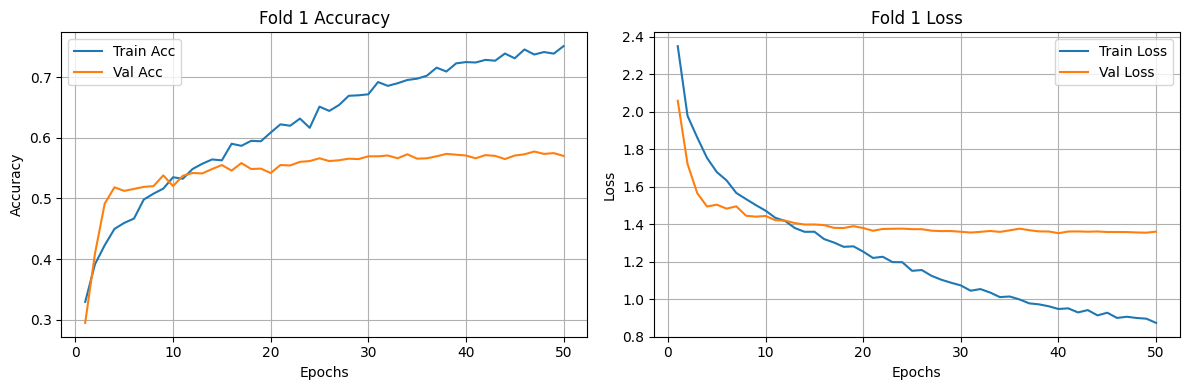

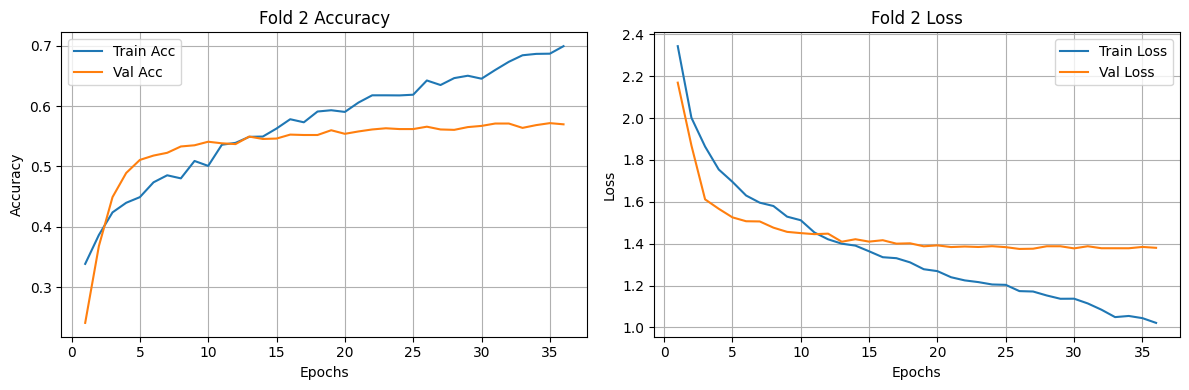

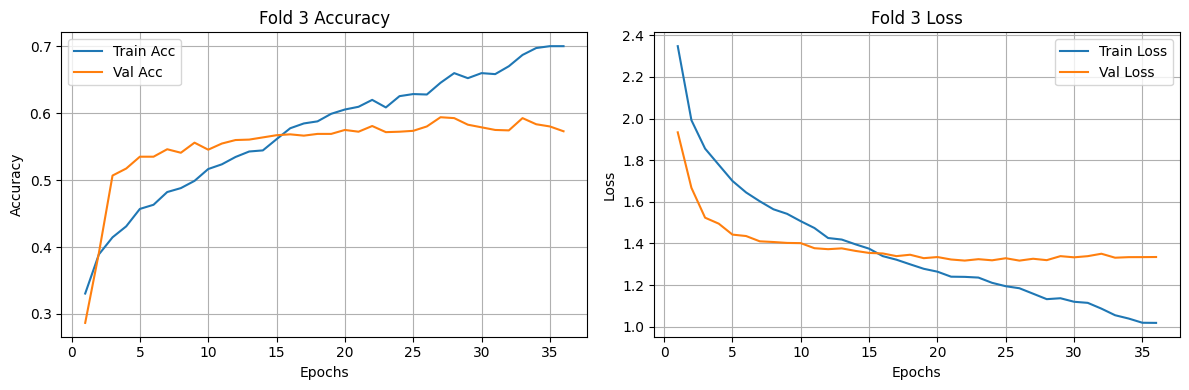

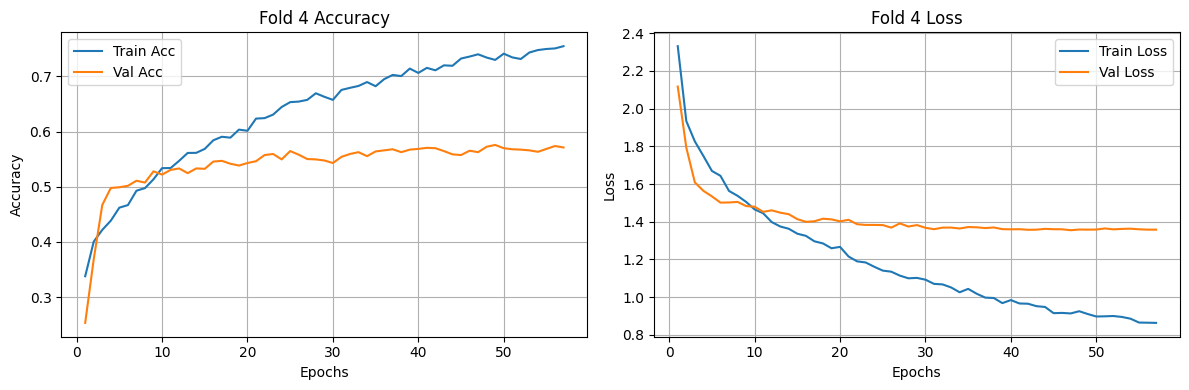

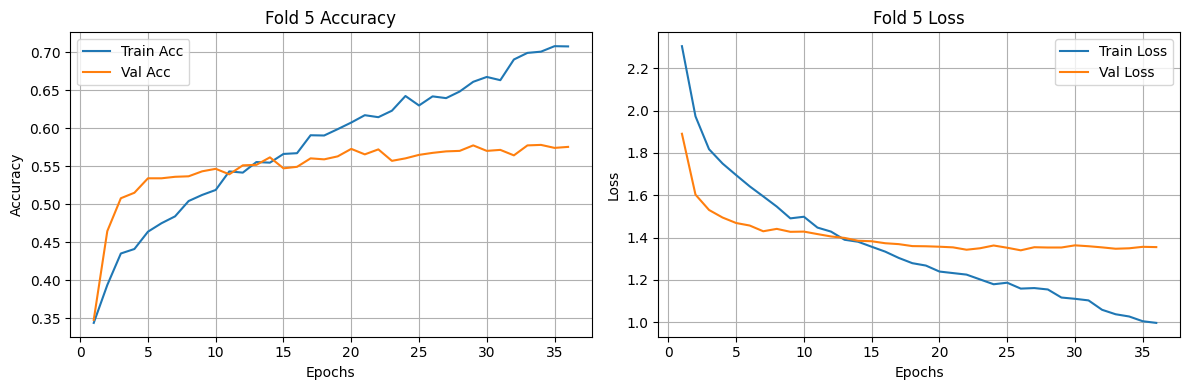


Loading best model for evaluation...
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
               precision    recall  f1-score   support

         ANG       0.81      0.86      0.83      1271
         DIS       0.74      0.70      0.72      1271
         FEA       0.82      0.58      0.68      1271
         HAP       0.78      0.70      0.74      1271
         NEU       0.70      0.88      0.78      1271
         SAD       0.71      0.78      0.74      1271

    accuracy                           0.75      7626
   macro avg       0.76      0.75      0.75      7626
weighted avg       0.76      0.75      0.75      7626



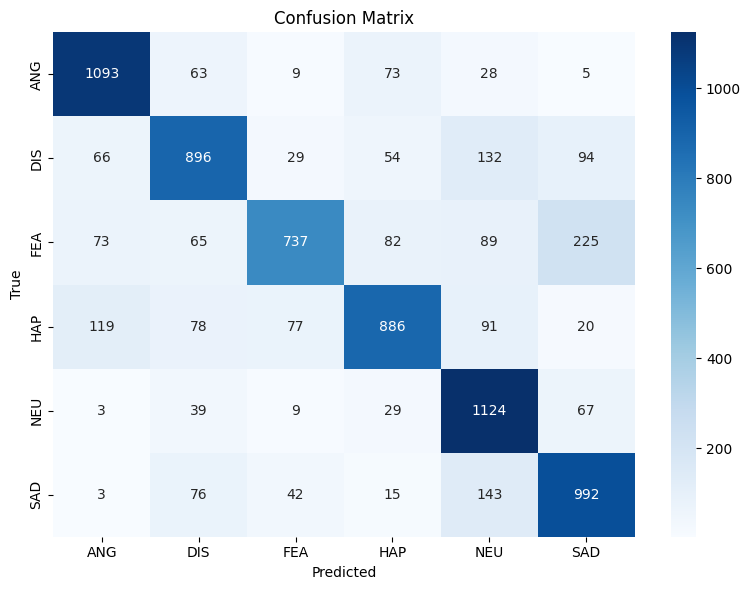

In [6]:
# ---------------------- Accuracy Table ----------------------
fold_results = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(5)],
    "Accuracy": [f"{acc:.4f}" for acc in fold_accuracies]
})
print("\nFold-wise Accuracy:")
print(fold_results)

# ---------------------- Step 7 :Accuracy and Loss Plot ----------------------
def plot_folds(histories):
    for i, history in enumerate(histories):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label='Train Acc')
        plt.plot(epochs, val_acc, label='Val Acc')
        plt.title(f'Fold {i+1} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label='Train Loss')
        plt.plot(epochs, val_loss, label='Val Loss')
        plt.title(f'Fold {i+1} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

plot_folds(histories)

# ----------------------Step 8: Final Evaluation ----------------------
print("\nLoading best model for evaluation...")
best_model = load_model("best_emotion_model-method1.h5")
y_pred = best_model.predict(X_reshaped)
y_pred_class = np.argmax(y_pred, axis=1)

print("\nClassification Report:\n", classification_report(y_resampled, y_pred_class, target_names=label_encoder.classes_))
conf_matrix = confusion_matrix(y_resampled, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Phase 3  :Music Recommendation

In [7]:
# ---------------------- Step 9 : Music Recommendation ----------------------
def recommend_music(emotion):
    load_dotenv()
    client_id = os.getenv("SPOTIPY_CLIENT_ID")
    client_secret = os.getenv("SPOTIPY_CLIENT_SECRET")
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

    mood_map = {
        'HAP': 'pop', 'SAD': 'classical', 'ANG': 'rock',
        'NEU': 'chill', 'FEA': 'metal', 'DIS': 'emo'
    }
    genre = mood_map.get(emotion, 'pop')
    results = sp.search(q=f"genre:{genre}", limit=5)
    print(f"\nTop tracks for {emotion} mood:")
    for track in results['tracks']['items']:
        print(f"{track['name']} by {track['artists'][0]['name']}")

# ----------------------Step 10 :  Prediction function ----------------------
def predict_and_recommend(file_path, model, label_encoder, scaler):
    feats = extract_features([file_path])
    feats_scaled = scaler.transform(feats).reshape(1, feats.shape[1], 1)
    preds = model.predict(feats_scaled)
    pred_label = np.argmax(preds)
    emotion = label_encoder.inverse_transform([pred_label])[0]

    print("Prediction Probabilities:")
    for cls, prob in zip(label_encoder.classes_, preds[0]):
        print(f"{cls}: {prob:.2%}")
    recommend_music(emotion)
    return emotion

# ---------------------- Step 11 :Prediction on Sample Audio ---------------------
def test_audio_prediction(audio_path):
    actual = os.path.basename(audio_path).split("_")[2]
    predicted = predict_and_recommend(audio_path, best_model, label_encoder, scaler)
    print(f"\nFile: {os.path.basename(audio_path)}")
    print(f"Actual Emotion:    {actual}")
    print(f"Predicted Emotion: {predicted}")
    print("-------------------------------------------------------------")

In [8]:

# Example audio predictions
test_audio_prediction("AudioWAV/1002_IEO_ANG_HI.wav")
test_audio_prediction("AudioWAV/1059_WSI_HAP_XX.wav")
test_audio_prediction("AudioWAV/1042_IEO_FEA_HI.wav")
test_audio_prediction("AudioWAV/1013_IEO_DIS_HI.wav")
test_audio_prediction("AudioWAV/1060_TAI_SAD_XX.wav")
test_audio_prediction("AudioWAV/1088_IWW_NEU_XX.wav")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction Probabilities:
ANG: 35.39%
DIS: 52.19%
FEA: 3.33%
HAP: 8.34%
NEU: 0.49%
SAD: 0.27%

Top tracks for DIS mood:
The Middle by Jimmy Eat World
Misery Business by Paramore
Hard Times by Paramore
Fuck Love by XXXTENTACION
Falling Down - Bonus Track by Lil Peep

File: 1002_IEO_ANG_HI.wav
Actual Emotion:    ANG
Predicted Emotion: DIS
-------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Probabilities:
ANG: 54.77%
DIS: 4.79%
FEA: 3.50%
HAP: 35.19%
NEU: 0.64%
SAD: 1.11%

Top tracks for ANG mood:
505 by Arctic Monkeys
Sweater Weather by The Neighbourhood
Dreams - 2004 Remaster by Fleetwood Mac
Mr. Brightside by The Killers
Iris by The Goo Goo Dolls

File: 1059_WSI_HAP_XX.wav
Actual Emotion:    HAP
Predicted Emotion: ANG
-------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction Probabilities:
ANG: 26.11%
DIS: 16.98%
FEA: 48.73%
HAP: 5.22%
NE